In [2]:
from os import sys
import os
sys.path.append('../')

%matplotlib widget

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from aircraft import airplane
import propellers as prop

plt.style.use('../basic_plotter.mplstyle')

# Simple aerodynamic Model of Vehicle
CD0 = 0.018         # Zero lift drag coefficient
k   = 0.03          # Induced drag coefficient (1/(pi*AR*e))

# Static conditions
rho0 = 1.225        # Standard seal level air density for now
mass = 1.563 + 0.230 # Estimated with virtual bolt included
span = 2.54
chord = 0.149
linus = airplane(mass, chord, span)
linus_prop = prop.aeronaut11x7_estimatedBEN()

# Operating point variation
V_inf = np.linspace(8, 25.7, 30)      # Airspeed in meters per second to check operating point
throttle = np.linspace(0, 1, 20)       # Throttle as a floating fraction, for defining thrust as fraction of cruise thrust

# Meshing the inputs
V_INF_op, THROTTLE = np.meshgrid(V_inf, throttle)

# Calculating h dot from X and V
q = 0.5 * rho0 * V_INF_op**2
X_T_createv_cruise = (CD0 * q * linus.area) + (k * (q*linus.area)**-1 * linus.weight**2)
X_T_op = X_T_createv_cruise * THROTTLE
h_dot_op = (-X_T_createv_cruise * V_INF_op * linus.weight**-1) + (X_T_op * V_INF_op * linus.weight**-1)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_26993/1598616684.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax1)


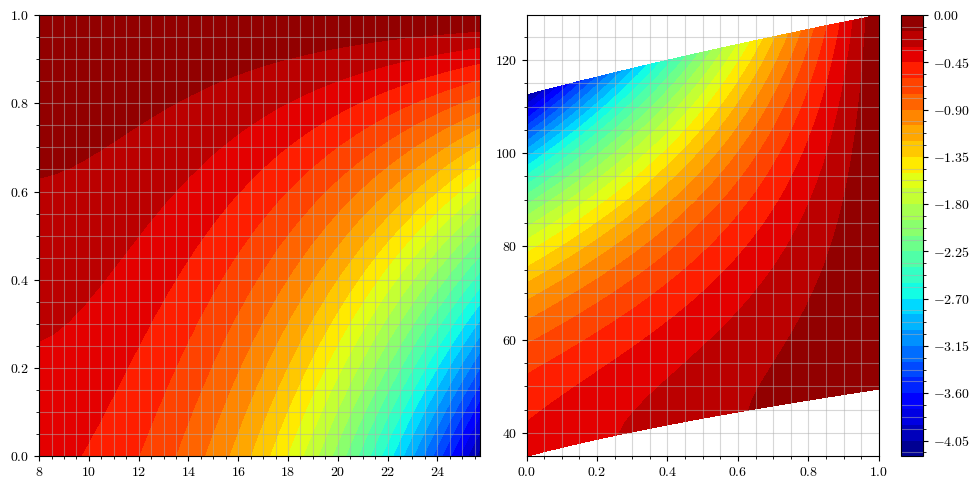

In [3]:
# Getting Estimates for propeller RPM
N_op = np.zeros(np.shape(V_INF_op))

for j, v in enumerate(V_inf):
    for i, x_t_createv in enumerate(X_T_op[:,j]):
        N_op[i, j] = linus_prop.getRPM(x_t_createv, rho0, v, n_guess=100)

fig = plt.figure(figsize=(10,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.contourf(V_INF_op, THROTTLE, h_dot_op, cmap="jet", levels=30)
pcm = ax1.contourf(THROTTLE, N_op, h_dot_op, cmap="jet", levels=30)
fig.colorbar(pcm, ax=ax1)
plt.show()

Only required inputs are:  
* N_op
* X_T_op
* V_INF_op

In [4]:
from sympy import init_printing
from sympy import *
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget
plt.style.use('../basic_plotter.mplstyle')
# Defining static conditions for cruise
[n_0, V_0, rho_0, C_D_0, X_T_0, h_dot_0]= symbols('n_0 V_0 \\rho_0 C_{D_0} X_{T_0} \dot{h}_0')
rho_0 = 1.225

# Defining complete input variables
[V_T, V,  U_dot, W_dot, h_dot, theta, n, rho, D, m, g, S, P, T] = symbols('V_T V \dot{U} \dot{W} \\dot{h} \\theta n \\rho D m g S P T')

# Defining outputs
[C_D, C_T, J, alpha] = symbols('C_D C_T J \\alpha')

dV = Symbol('\\Delta V')
dU_dot = Symbol('\\Delta \dot{U}')
dW_dot = Symbol('\\Delta \dot{W}')
dh_dot = Symbol('\\Delta \dot{h}')

dtheta = Symbol('\\Delta \\theta')
dn = Symbol('\\Delta n')
drho = Symbol('\\Delta \\rho')
dg = Symbol('\\Delta g')

## Defining the Operating Points at Cruise (For CREATeV)

Assumptions:
* No wind to speak of
* Perturbations happen one at a time, not all at once
* Cruising at conditions defined by some assumed drag polar
  * Drag Polar: $C_D = C_{D_0} + k C_L^2$
  * $C_{D_0} = 0.018$
  * $AR = \frac{b^2}{S} = 6.2V_op[i]^2 / (6.28 * 0.395) = 15.89$
  * $k = 1 / (\pi AR e) = 0.03$ (Assumption from range of polar results (0.029 to 0.0556))

In [5]:
# Defining Operating Points in Cruise (cruise_operatingpoints_working.ipynb)
# Based on 20x8 and CREATeV performance (cd0 = 0.018, k = 0.03)
area = linus.area
CL_alpha = np.array([12.02184177, -10.35785056])

## Complete Drag & Drag Equations

In [6]:
# Total Drag
C_D_total = (1/2 * rho * V_T**2 * S)**-1 * (-((U_dot+W_dot*alpha)*m) - (m * g * (-h_dot/V_T)) + X_T_0)
C_D_total

2.0*(X_{T_0} - m*(\alpha*\dot{W} + \dot{U}) + \dot{h}*g*m/V_T)/(S*V_T**2*\rho)

In [7]:
# Total Lift
C_L_total = (1/2 * rho * V_T**2 * S)**-1 * ( m* (U_dot*alpha - W_dot) + (m*g) - X_T_0*alpha )
C_L_total

2.0*(-X_{T_0}*\alpha + g*m + m*(\alpha*\dot{U} - \dot{W}))/(S*V_T**2*\rho)

In [8]:
# Sub Equation 1 (AOA)
V_T = V * sqrt(1.225) * sqrt(rho)**-1
alpha = asin(-h_dot/V_T) + theta
#rho = P * (287 * (T+273.15))**-1 
# Subsub Equation 2 (Advance ratio)
J = V_T / (n * D)
# Sub Equation 3 (Thrust coefficient)
C_T_11x7 = 0.10244 - 0.0023939*J - 0.22146*J**2 + 0.047003*J**3 + 0.038813*J**4
X_T_11x7 = C_T_11x7 * rho * n**2 * D**4
# Primary equation
C_D = (0.5 * rho * V_T**2 * S)**-1 * (-(U_dot*m + W_dot*m*alpha) + (m * g * (-h_dot/V_T)) + (C_T_11x7 * rho * n**2 * D**4))
C_L = (0.5 * rho * V_T**2 * S)**-1 * ((U_dot*m*alpha - W_dot*m) + (m * g * cos(asin(-h_dot/V_T))) - (C_T_11x7 * rho * n**2 * D**4)*alpha)
# D = C_D * 0.5 * rho * V**2 * S

# Primary equation local operating point
# C_D_0 = (0.5 * rho * V**2 * S)**-1 * (-(U_dot*m + W_dot*m*alpha) + (m * g * (-h_dot/V)) + (C_T * rho * n**2 * D**4))
C_D_0 = (0.5 * rho_0 * V_0**2 * S)**-1 * (X_T_0 + (m * g * (-h_dot_0*V_0**-1)))
C_L_0 = (0.5 * rho_0 * V_0**2 * S)**-1 * ((m * g))

C_L

1.63265306122449*(-D**4*\rho*n**2*(\theta - asin(0.903507902905251*\dot{h}*sqrt(\rho)/V))*(0.10244 - 0.00264956177173698*V/(D*sqrt(\rho)*n) - 0.2712885*V**2/(D**2*\rho*n**2) + 0.0637279151791084*V**3/(D**3*\rho**(3/2)*n**3) + 0.058243758125*V**4/(D**4*\rho**2*n**4)) + \dot{U}*m*(\theta - asin(0.903507902905251*\dot{h}*sqrt(\rho)/V)) - \dot{W}*m + g*m*sqrt(1 - 0.816326530612245*\dot{h}**2*\rho/V**2))/(S*V**2)

In [9]:
dC_D_dV = diff(C_D, V)
dC_D_dU_dot = diff(C_D, U_dot)
dC_D_dW_dot = diff(C_D, W_dot)
dC_D_dh_dot = diff(C_D, h_dot)
dC_D_dtheta = diff(C_D, theta)
dC_D_dn = diff(C_D, n)
dC_D_drho = diff(C_D, rho)
dC_D_dP = diff(C_D, P)
dC_D_dT = diff(C_D, T)
dC_D_dg = diff(C_D, g)

## Getting 1% Deviation Estimates

Taking the ratio of terms t1, representing the partial derivatives of CD with respect to each input variable, then 

In [10]:
per_diff = 0.05

C_D_base_vec = np.zeros(np.shape(V_INF_op))
C_L_base_vec = np.zeros(np.shape(V_INF_op))

dV_vec = np.zeros(np.shape(V_INF_op))
dU_dot_vec = np.zeros(np.shape(V_INF_op))
dW_dot_vec = np.zeros(np.shape(V_INF_op))
dh_dot_vec = np.zeros(np.shape(V_INF_op))
dtheta_vec = np.zeros(np.shape(V_INF_op))
dn_vec = np.zeros(np.shape(V_INF_op))
drho_vec = np.zeros(np.shape(V_INF_op))
dg_vec = np.zeros(np.shape(V_INF_op))

for j, v in enumerate(V_inf):
    for i, x_t_createv in enumerate(X_T_op[:,j]):
        C_D_0_base = float(C_D_0.subs([(rho_0, 1.225), (V_0, v), (S, area), (X_T_0, x_t_createv), (h_dot_0, h_dot_op[i,j]), (g, 9.807), (m, linus.mass)]))
        C_L_0_base = float(C_L_0.subs([(rho_0, 1.225), (V_0, v), (S, area), (X_T_0, x_t_createv), (g, 9.807), (m, linus.mass)]))
        theta_base = np.deg2rad(CL_alpha[0]*C_L_0_base**1 + CL_alpha[1])

        tdV = dC_D_dV.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdU_dot = dC_D_dU_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdW_dot = dC_D_dW_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdh_dot = dC_D_dh_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdtheta = dC_D_dtheta.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdrho = dC_D_drho.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807)])
        tdn = dC_D_dn.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdP = dC_D_dP.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdT = dC_D_dT.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdg = dC_D_dg.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])

        total_term = tdV*dV + tdU_dot*dU_dot + tdW_dot*dW_dot + tdh_dot*dh_dot + tdtheta*dtheta + tdn*dn + tdrho*drho + tdg*dg
        total_term

        dV = float((-C_D_0_base * (per_diff)) / (tdV))
        dU_dot = float((-C_D_0_base * (per_diff)) / (tdU_dot))
        dW_dot = float((-C_D_0_base * (per_diff)) / (tdW_dot))
        dh_dot = float((-C_D_0_base * (per_diff)) / (tdh_dot))
        dtheta = ((-C_D_0_base * (per_diff)) / (tdtheta))
        dn = float((-C_D_0_base * (per_diff)) / (tdn))
        drho = float((-C_D_0_base * (per_diff)) / (tdrho))
        dg = ((-C_D_0_base * (per_diff)) / (tdg))

        dV_vec[i,j] = np.abs(dV)
        dU_dot_vec[i,j] = np.abs(dU_dot)
        dW_dot_vec[i,j] = np.abs(dW_dot)
        dh_dot_vec[i,j] = np.abs(dh_dot)
        dtheta_vec[i,j] = np.abs(0.0)
        dn_vec[i,j] = np.abs(dn)
        drho_vec[i,j] = np.abs(drho)
        dg_vec[i,j] = np.abs(0.0)
        C_D_base_vec[i,j] = np.abs(C_D_0_base)
        C_L_base_vec[i,j] = np.abs(C_L_0_base)

result_list = [C_L_base_vec, C_D_base_vec, dV_vec, dU_dot_vec, dW_dot_vec, dh_dot_vec, THROTTLE, dn_vec, drho_vec, N_op]
labels = ['$C_L$', '$C_D$', '$\Delta V$', '$\Delta \dot{U}$', '$\Delta \dot{W}$', '$\Delta \dot{h}$', 'Throttle', '$\Delta n$', '$\Delta \\rho$', '$n$']

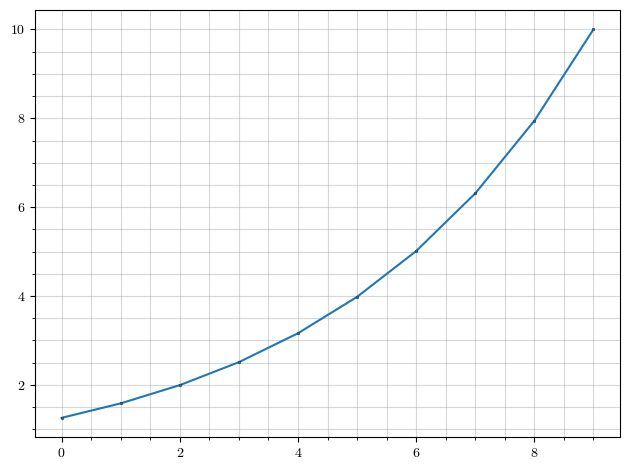

In [17]:
x = np.logspace(0.1, 1, 10)
plt.figure()
plt.plot(x)

[<AxesSubplot:> <AxesSubplot:>]
$C_L$
$C_D$
$\Delta V$
$\Delta \dot{U}$
$\Delta \dot{W}$
$\Delta \dot{h}$
Throttle
$\Delta n$
$\Delta \rho$
$n$


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_26993/2930717230.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax)


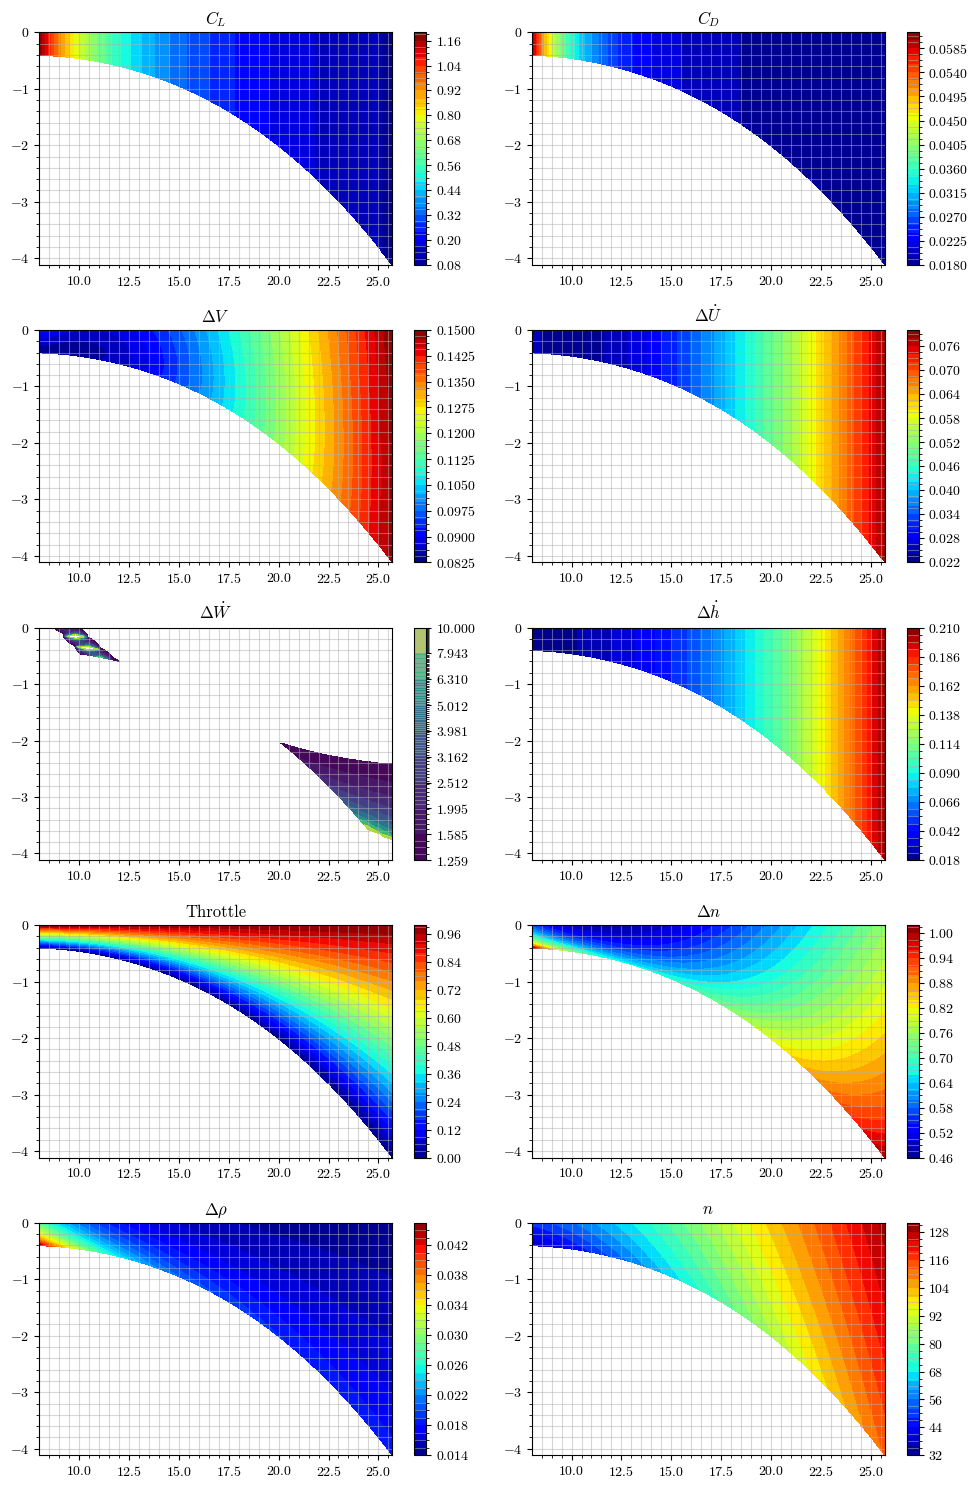

In [18]:
fig, axs = plt.subplots(5, 2, layout='tight')
print(axs[0])
fig.set_size_inches(10,15)
for i, ax in enumerate(axs.flat):
    if i == 4:
        levels = np.logspace(0.1, 1, 10)
        pcm = ax.contourf(V_INF_op, h_dot_op, result_list[i], cmap='jet', levels=levels)
    else:
        pcm = ax.contourf(V_INF_op, h_dot_op, result_list[i], cmap='jet', levels=30)
    print(labels[i])
    ax.set_title(labels[i])
    fig.colorbar(pcm, ax=ax)

In [ ]:
dC_L_dV = diff(C_L, V)
dC_L_dU_dot = diff(C_L, U_dot)
dC_L_dW_dot = diff(C_L, W_dot)
dC_L_dh_dot = diff(C_L, h_dot)
dC_L_dtheta = diff(C_L, theta)
dC_L_dn = diff(C_L, n)
dC_L_drho = diff(C_L, rho)
dC_L_dP = diff(C_L, P)
dC_L_dT = diff(C_L, T)
dC_L_dg = diff(C_L, g)

In [ ]:
C_L

1.63265306122449*(-D**4*\rho*n**2*(\theta - asin(0.903507902905251*\dot{h}*sqrt(\rho)/V))*(0.10244 - 0.00264956177173698*V/(D*sqrt(\rho)*n) - 0.2712885*V**2/(D**2*\rho*n**2) + 0.0637279151791084*V**3/(D**3*\rho**(3/2)*n**3) + 0.058243758125*V**4/(D**4*\rho**2*n**4)) + \dot{U}*m*(\theta - asin(0.903507902905251*\dot{h}*sqrt(\rho)/V)) - \dot{W}*m + g*m*sqrt(1 - 0.816326530612245*\dot{h}**2*\rho/V**2))/(S*V**2)

In [ ]:
dC_L_dh_dot

1.63265306122449*(0.903507902905251*D**4*\rho**(3/2)*n**2*(0.10244 - 0.00264956177173698*V/(D*sqrt(\rho)*n) - 0.2712885*V**2/(D**2*\rho*n**2) + 0.0637279151791084*V**3/(D**3*\rho**(3/2)*n**3) + 0.058243758125*V**4/(D**4*\rho**2*n**4))/(V*sqrt(1 - 0.816326530612245*\dot{h}**2*\rho/V**2)) - 0.903507902905251*\dot{U}*sqrt(\rho)*m/(V*sqrt(1 - 0.816326530612245*\dot{h}**2*\rho/V**2)) - 0.816326530612245*\dot{h}*\rho*g*m/(V**2*sqrt(1 - 0.816326530612245*\dot{h}**2*\rho/V**2)))/(S*V**2)

In [ ]:
per_diff = 0.05

C_D_base_vec = np.zeros(np.shape(V_INF_op))
C_L_base_vec = np.zeros(np.shape(V_INF_op))

dV_vec = np.zeros(np.shape(V_INF_op))
dU_dot_vec = np.zeros(np.shape(V_INF_op))
dW_dot_vec = np.zeros(np.shape(V_INF_op))
dh_dot_vec = np.zeros(np.shape(V_INF_op))
dtheta_vec = np.zeros(np.shape(V_INF_op))
dn_vec = np.zeros(np.shape(V_INF_op))
drho_vec = np.zeros(np.shape(V_INF_op))
dg_vec = np.zeros(np.shape(V_INF_op))

for j, v in enumerate(V_inf):
    for i, x_t_createv in enumerate(X_T_op[:,j]):
        C_D_0_base = float(C_D_0.subs([(rho_0, 1.225), (V_0, v), (S, area), (X_T_0, x_t_createv), (h_dot_0, h_dot_op[i,j]), (g, 9.807), (m, linus.mass)]))
        C_L_0_base = float(C_L_0.subs([(rho_0, 1.225), (V_0, v), (S, area), (X_T_0, x_t_createv), (g, 9.807), (m, linus.mass)]))
        theta_base = np.deg2rad(CL_alpha[0]*C_L_0_base**1 + CL_alpha[1])

        tdV = dC_L_dV.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (theta, theta_base), (g, 9.807), (m, linus.mass)])
        tdU_dot = dC_L_dU_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdW_dot = dC_L_dW_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdh_dot = dC_L_dh_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdtheta = dC_L_dtheta.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdrho = dC_L_drho.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdn = dC_L_dn.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdP = dC_L_dP.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdT = dC_L_dT.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdg = dC_L_dg.subs([(h_dot, h_dot_op[i,j]), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])

        total_term = tdV*dV + tdU_dot*dU_dot + tdW_dot*dW_dot + tdh_dot*dh_dot + tdtheta*dtheta + tdn*dn + tdrho*drho + tdg*dg
        total_term

        dV = float((-C_L_0_base * (per_diff)) / (tdV))
        dU_dot = float((-C_L_0_base * (per_diff)) / (tdU_dot))
        dW_dot = float((-C_L_0_base * (per_diff)) / (tdW_dot))
        dh_dot = float((-C_L_0_base * (per_diff)) / (tdh_dot))
        dtheta = ((-C_L_0_base * (per_diff)) / (tdtheta))
        dn = float((-C_L_0_base * (per_diff)) / (tdn))
        drho = float((-C_L_0_base * (per_diff)) / (tdrho))
        dg = ((-C_L_0_base * (per_diff)) / (tdg))

        dV_vec[i,j] = np.abs(dV)
        dU_dot_vec[i,j] = np.abs(dU_dot)
        dW_dot_vec[i,j] = np.abs(dW_dot)
        dh_dot_vec[i,j] = np.abs(dh_dot)
        dtheta_vec[i,j] = np.abs(0.0)
        dn_vec[i,j] = np.abs(dn)
        drho_vec[i,j] = np.abs(drho)
        dg_vec[i,j] = np.abs(0.0)
        C_D_base_vec[i,j] = np.abs(C_D_0_base)
        C_L_base_vec[i,j] = np.abs(C_L_0_base)

result_list = [C_L_base_vec, C_D_base_vec, dV_vec, dU_dot_vec, dW_dot_vec, dh_dot_vec, THROTTLE, dn_vec, drho_vec, N_op]
labels = ['$C_L$', '$C_D$', '$\Delta V$', '$\Delta \dot{U}$', '$\Delta \dot{W}$', '$\Delta \dot{h}$', 'Throttle', '$\Delta n$', '$\Delta \\rho$', '$n$']

In [ ]:
dC_L_dh_dot

1.63265306122449*(0.903507902905251*D**4*\rho**(3/2)*n**2*(0.10244 - 0.00264956177173698*V/(D*sqrt(\rho)*n) - 0.2712885*V**2/(D**2*\rho*n**2) + 0.0637279151791084*V**3/(D**3*\rho**(3/2)*n**3) + 0.058243758125*V**4/(D**4*\rho**2*n**4))/(V*sqrt(1 - 0.816326530612245*\dot{h}**2*\rho/V**2)) - 0.903507902905251*\dot{U}*sqrt(\rho)*m/(V*sqrt(1 - 0.816326530612245*\dot{h}**2*\rho/V**2)) - 0.816326530612245*\dot{h}*\rho*g*m/(V**2*sqrt(1 - 0.816326530612245*\dot{h}**2*\rho/V**2)))/(S*V**2)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_20449/3026417709.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax)
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


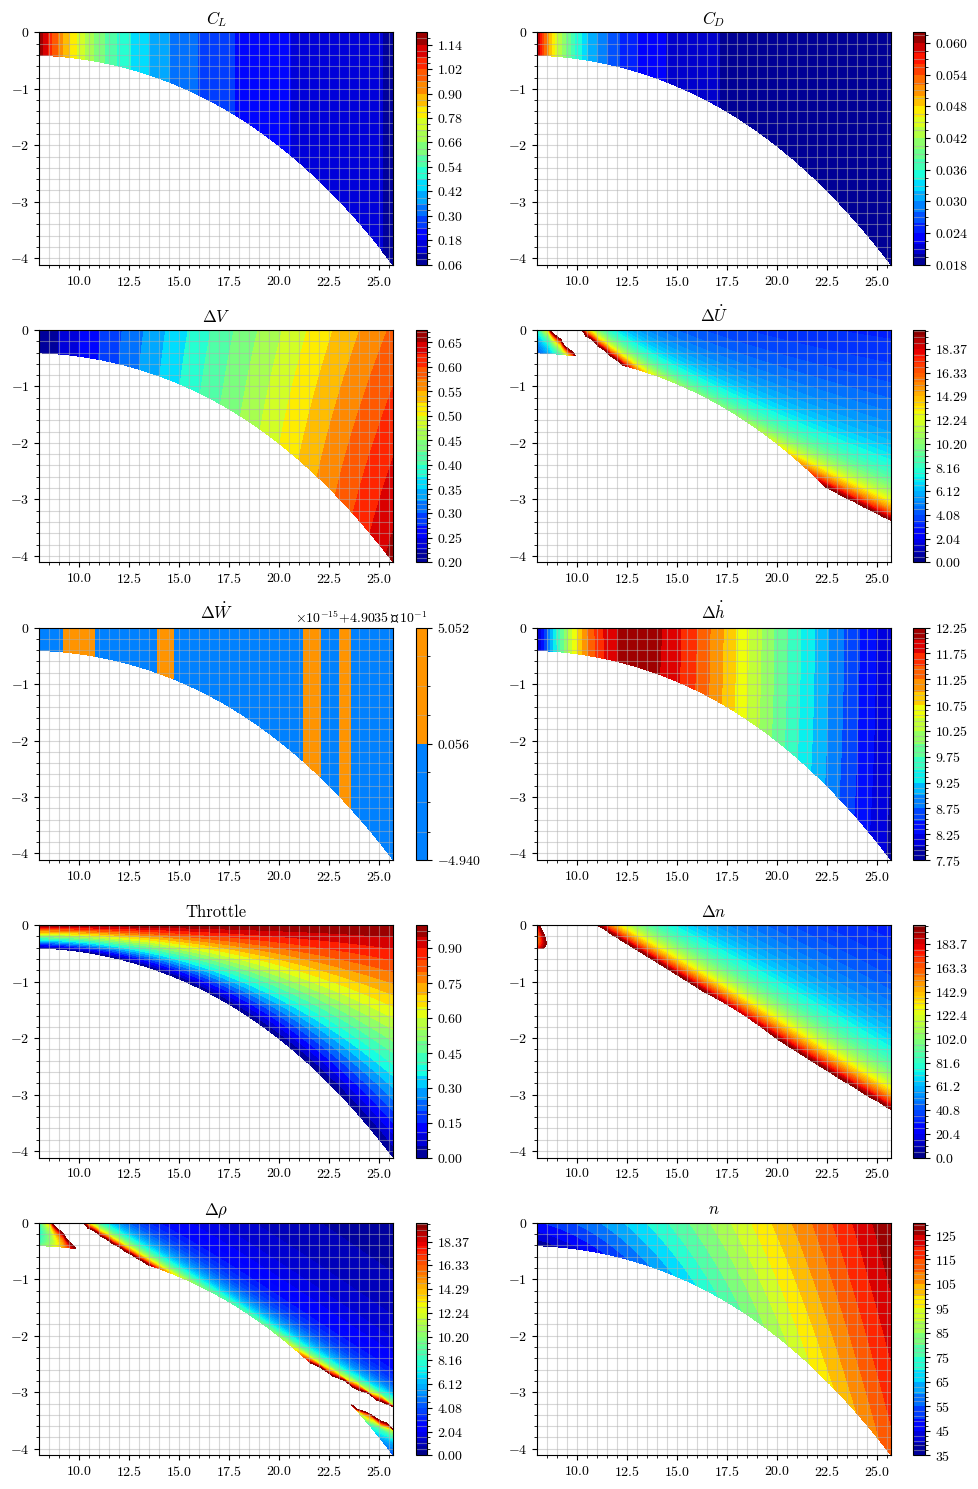

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


In [ ]:
from matplotlib import colors
fig, axs = plt.subplots(5, 2, layout='tight')
fig.set_size_inches(10,15)
for i, ax in enumerate(axs.flat):
    if i == 3:
        levels = np.linspace(0, 20)
        pcm = ax.contourf(V_INF_op, h_dot_op, result_list[i], cmap='jet', levels=levels)
    elif i == 7:
        levels = np.linspace(0, 200)
        pcm = ax.contourf(V_INF_op, h_dot_op, result_list[i], cmap='jet', levels=levels)
    elif i == 8:
        levels = np.linspace(0, 20)
        pcm = ax.contourf(V_INF_op, h_dot_op, result_list[i], cmap='jet', levels=levels)
    else:
        pcm = ax.contourf(V_INF_op, h_dot_op, result_list[i], cmap='jet', levels=20)
    ax.set_title(labels[i])
    fig.colorbar(pcm, ax=ax)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_20449/2766226519.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax1)


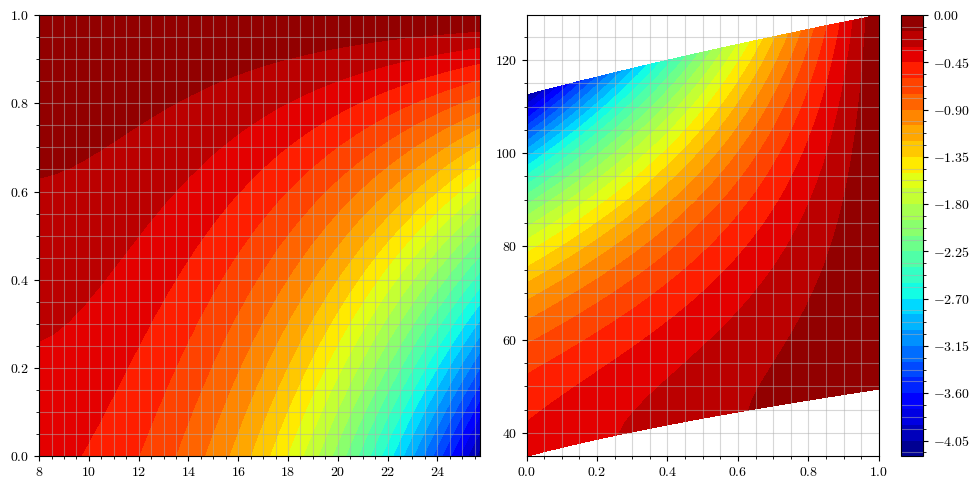

In [ ]:
fig = plt.figure(figsize=(10,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.contourf(V_INF_op, THROTTLE, h_dot_op, cmap="jet", levels=30)
pcm = ax1.contourf(THROTTLE, N_op, h_dot_op, cmap="jet", levels=30)
fig.colorbar(pcm, ax=ax1)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21954/1611526574.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


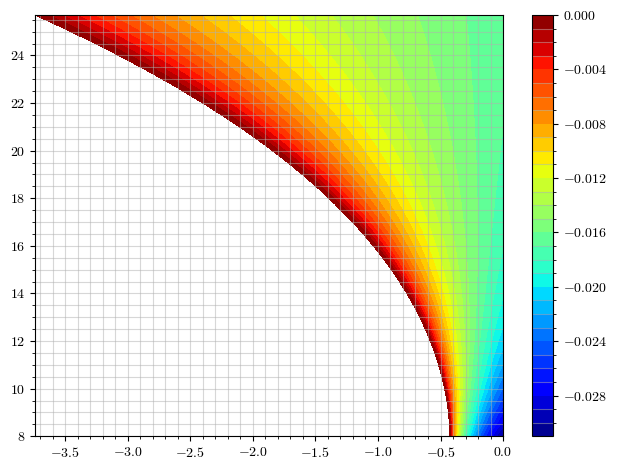

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_15131/1611526574.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


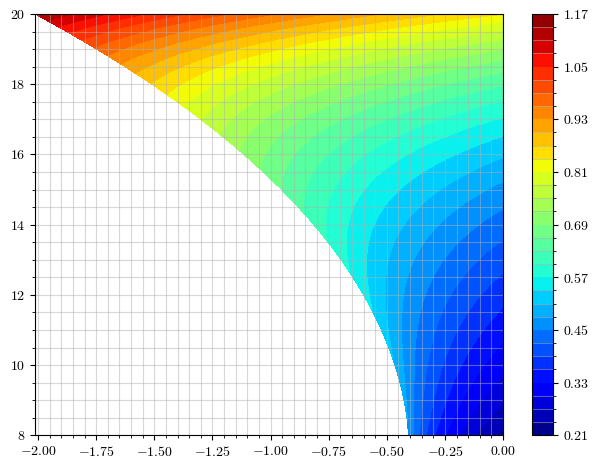

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_15131/1611526574.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


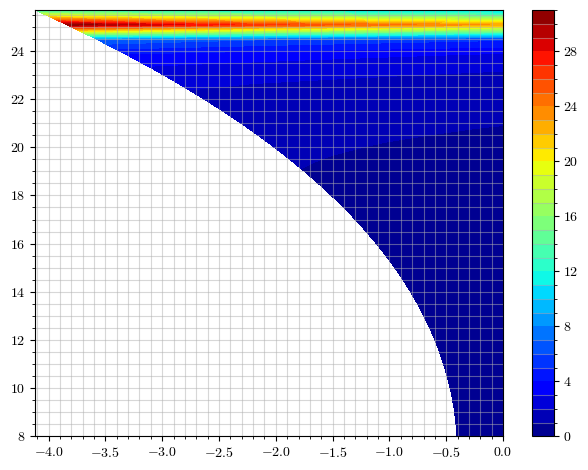

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_20449/1611526574.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


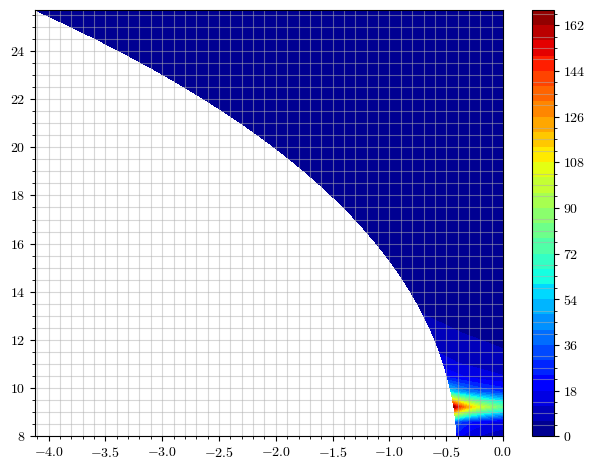

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_20449/1611526574.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


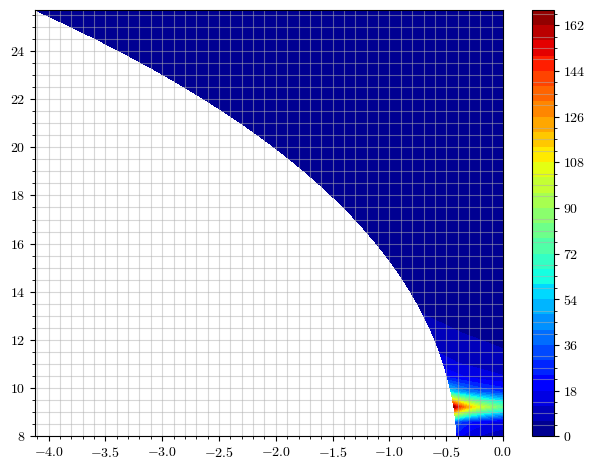

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_20449/1611526574.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


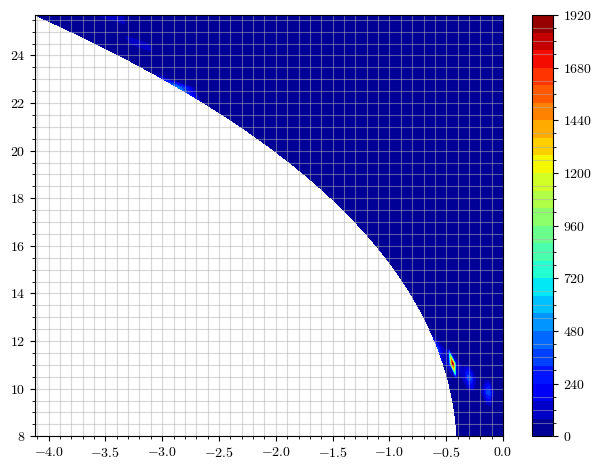

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_20449/1611526574.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


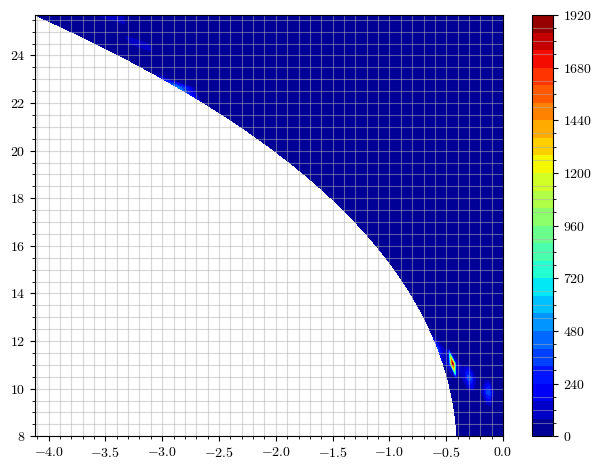

In [ ]:
plt.figure()
plt.contourf(h_dot_op, V_INF_op, drho_vec, cmap="jet", levels=30)
plt.colorbar()
plt.show()

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_20449/2788661297.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


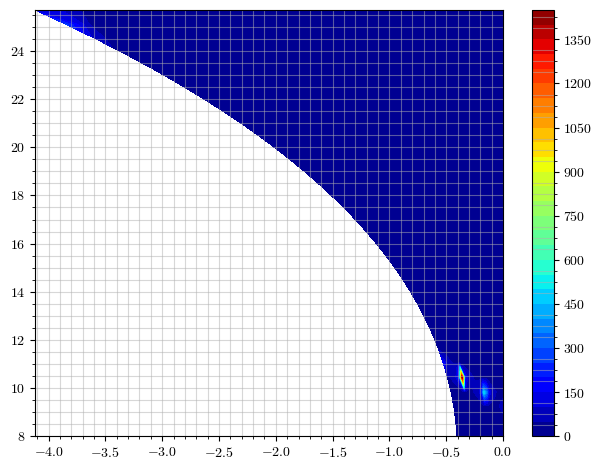

In [ ]:
plt.figure()
plt.contourf(h_dot_op, V_INF_op, dU_dot_vec, cmap="jet", levels=30)
plt.colorbar()
plt.show()

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_20449/738689557.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


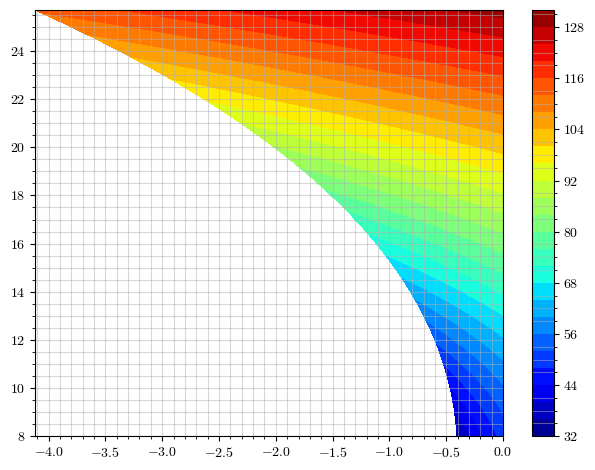

In [ ]:
plt.figure()
plt.contourf(h_dot_op, V_INF_op, N_op, cmap="jet", levels=30)
plt.colorbar()
plt.show()